<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [39]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, datetime, timedelta

In [40]:
uploaded3 = files.upload()

Saving L3.csv to L3 (2).csv


In [41]:
df = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))

In [42]:
NUM_TIME_BUCKETS = 96
NUM_DAYS_BACK = 2
TRAIN_DS_START = datetime(2019, 1, 3, 0, 0, 0)
TRAIN_DS_END = datetime(2019, 2, 28, 23, 59, 59)
VALIDATE_DS_START = datetime(2019, 3, 1, 0, 0, 0)
VALIDATE_DS_END = datetime(2019, 3, 31, 23, 59, 59)

In [43]:
df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
df['Date'] = pd.to_datetime(df['Date']).dt.date
df

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-01,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,260.604390,260.794296,261.618119,260.410437,256.860222,258.367665,259.267954,255.889186,256.234454,251.733526,253.060736,169.000653,174.316712,178.301884,177.104918,171.312698,164.677503,162.545790,163.696737,170.815170,165.797771,167.774777,162.219537,166.467952,170.952205,176.889430,185.207906,181.386608,181.008994,181.457673,184.951047,187.337285,190.128226,184.331248,183.509355,176.219448,167.887276,158.470484,150.323493,143.850835
1,139251010000000953,2019-01-02,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,262.614308,263.173392,263.352288,263.732740,260.200462,259.552441,261.542219,257.306632,257.454331,250.630975,246.677790,173.395331,173.247478,179.119319,181.130723,172.431674,167.940838,163.201839,159.947323,165.188458,158.381998,163.432975,151.094304,158.090667,159.554482,164.175128,174.279432,170.459428,168.864455,170.290711,169.613266,171.382665,161.363754,152.990980,146.391072,150.247456,143.614168,135.241240,131.278230,122.201884
2,139251010000000953,2019-01-03,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.687940,172.159325,167.239343,166.621991,155.375629,146.709297,153.780523,145.743225,149.150742,138.501170,146.525020,148.044261,156.138623,169.157942,162.477838,162.238434,160.321249,161.024958,166.956953,165.855017,155.794104,155.492025,156.603946,147.835247,138.821851,133.105765,122.270591
3,139251010000000953,2019-01-04,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
4,139251010000000953,2019-01-05,105.965670,100.102905,91.755365,86.466442,82.576150,75.976198,72.498847,69.908311,73.935389,70.05197

In [44]:
def build_sequence_data(df, num_days_back = 2):
  df_join = pd.DataFrame.copy(df)
  for i in range(1, num_days_back+1):
    df_copy = pd.DataFrame.copy(df)
    df_copy['Date'] = df_copy['Date'] + pd.Timedelta(days=i)
    df_join = df_copy.set_index(['Id', 'Date']).join(
        df_join.set_index(['Id', 'Date']), lsuffix=f'_d{i}'
        ).reset_index()
  return df_join

df_join = build_sequence_data(df, 2)
df_join

,Id,Date,TB1_d2,TB2_d2,TB3_d2,TB4_d2,TB5_d2,TB6_d2,TB7_d2,TB8_d2,TB9_d2,TB10_d2,TB11_d2,TB12_d2,TB13_d2,TB14_d2,TB15_d2,TB16_d2,TB17_d2,TB18_d2,TB19_d2,TB20_d2,TB21_d2,TB22_d2,TB23_d2,TB24_d2,TB25_d2,TB26_d2,TB27_d2,TB28_d2,TB29_d2,TB30_d2,TB31_d2,TB32_d2,TB33_d2,TB34_d2,TB35_d2,TB36_d2,TB37_d2,TB38_d2,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-03,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.687940,172.159325,167.239343,166.621991,155.375629,146.709297,153.780523,145.743225,149.150742,138.501170,146.525020,148.044261,156.138623,169.157942,162.477838,162.238434,160.321249,161.024958,166.956953,165.855017,155.794104,155.492025,156.603946,147.835247,138.821851,133.105765,122.270591
1,139251010000000953,2019-01-04,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
2,139251010000000953,2019-01-05,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,213.816471,212.354532,212.044959,209.876146,205.785208,204.174900,202.210582,197.883338,196.765659,194.937442,199.705543,146.997571,149.877208,149.409897,145.343126,139.917253,133.280887,135.290267,139.268966,145.233556,142.589052,146.036964,142.429026,147.651855,153.447582,159.910535,169.542790,168.359551,167.852225,168.971672,170.418985,169.853306,167.133301,160.006060,152.007337,147.060011,138.041396,127.561116,120.735603,112.255813
3,139251010000000953,2019-01-06,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,234.937747,231.418619,228.789198,225.491401,219.502831,221.578048,223.986592,223.096563,225.975580,223.169991,226.176978,163.062372,167.501747,170.377385,170.103222,164.890632,162.070590,162.503550,164.855752,173.306951,171.548207,173.759186,168.529624,173.200158,178.108721,183.704867,193.125190,189.540347,186.807804,187.606575,186.687995,185.425205,175.336742,165.560103,159.462675,154.280202,144.456001,134.385936,126.443107,117.613147
4,1392510100000009

In [45]:
df_train = df_join[((df_join['Date'] >= pd.Timestamp(TRAIN_DS_START)) & (df_join['Date'] <= pd.Timestamp(TRAIN_DS_END)))]
df_validate = df_join[((df_join['Date'] >= pd.Timestamp(VALIDATE_DS_START)) & (df_join['Date'] <= pd.Timestamp(VALIDATE_DS_END)))]

df_train

,Id,Date,TB1_d2,TB2_d2,TB3_d2,TB4_d2,TB5_d2,TB6_d2,TB7_d2,TB8_d2,TB9_d2,TB10_d2,TB11_d2,TB12_d2,TB13_d2,TB14_d2,TB15_d2,TB16_d2,TB17_d2,TB18_d2,TB19_d2,TB20_d2,TB21_d2,TB22_d2,TB23_d2,TB24_d2,TB25_d2,TB26_d2,TB27_d2,TB28_d2,TB29_d2,TB30_d2,TB31_d2,TB32_d2,TB33_d2,TB34_d2,TB35_d2,TB36_d2,TB37_d2,TB38_d2,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-03,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.687940,172.159325,167.239343,166.621991,155.375629,146.709297,153.780523,145.743225,149.150742,138.501170,146.525020,148.044261,156.138623,169.157942,162.477838,162.238434,160.321249,161.024958,166.956953,165.855017,155.794104,155.492025,156.603946,147.835247,138.821851,133.105765,122.270591
1,139251010000000953,2019-01-04,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
2,139251010000000953,2019-01-05,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,213.816471,212.354532,212.044959,209.876146,205.785208,204.174900,202.210582,197.883338,196.765659,194.937442,199.705543,146.997571,149.877208,149.409897,145.343126,139.917253,133.280887,135.290267,139.268966,145.233556,142.589052,146.036964,142.429026,147.651855,153.447582,159.910535,169.542790,168.359551,167.852225,168.971672,170.418985,169.853306,167.133301,160.006060,152.007337,147.060011,138.041396,127.561116,120.735603,112.255813
3,139251010000000953,2019-01-06,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,234.937747,231.418619,228.789198,225.491401,219.502831,221.578048,223.986592,223.096563,225.975580,223.169991,226.176978,163.062372,167.501747,170.377385,170.103222,164.890632,162.070590,162.503550,164.855752,173.306951,171.548207,173.759186,168.529624,173.200158,178.108721,183.704867,193.125190,189.540347,186.807804,187.606575,186.687995,185.425205,175.336742,165.560103,159.462675,154.280202,144.456001,134.385936,126.443107,117.613147
4,1392510100000009

In [46]:
def split_feature_labels(df, num_days_back = 2):
  x = df.iloc[:,2:2+96*num_days_back].values
  y = df.iloc[:,2+96:].values
  x = x.reshape([x.shape[0], x.shape[1], 1])
  y = y.reshape([y.shape[0], y.shape[1], 1])
  print(x.shape, y.shape)
  return (x, y)
x_train, y_train = split_feature_labels(df_train)
x_validate, y_validate = split_feature_labels(df_validate)

(5472, 192, 1) (5472, 192, 1)
(2976, 192, 1) (2976, 192, 1)


# Build A DNN Model 

In [47]:
import tensorflow as tf 
keras = tf.keras

BATCH_SIZE = 128

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# keras.layers.Lambda(lambda x: x * 200)
print(model.summary())
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(x_train, y_train, epochs=100, batch_size = BATCH_SIZE, callbacks=[lr_schedule])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

(1e-08, 0.1, 0.0, 200.0)

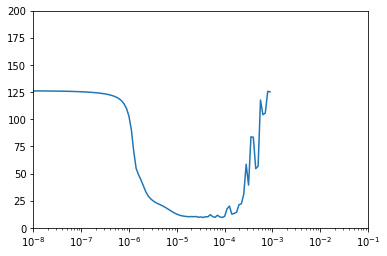

In [49]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 200])

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=30)

history = model.fit(x_train, y_train, epochs=500, batch_size = BATCH_SIZE,
                    validation_data=(x_validate, y_validate),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
43/43 [==============================] - 1s 14ms/step - loss: 125.7812 - mae: 126.2780 - val_loss: 220.5760 - val_mae: 221.0735
Epoch 2/500
43/43 [==============================] - 0s 9ms/step - loss: 125.1017 - mae: 125.5985 - val_loss: 219.3491 - val_mae: 219.8465
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 124.3675 - mae: 124.8642 - val_loss: 217.9805 - val_mae: 218.4779
Epoch 4/500
43/43 [==============================] - 0s 9ms/step - loss: 123.5227 - mae: 124.0193 - val_loss: 216.3280 - val_mae: 216.8254
Epoch 5/500
43/43 [==============================] - 0s 9ms/step - loss: 122.4672 - mae: 122.9639 - val_loss: 214.1530 - val_mae: 214.6505
Epoch 6/500
43/43 [==============================] - 0s 9ms/step - loss: 121.1060 - mae: 121.6026 - val_loss: 211.4651 - val_mae: 211.9626
Epoch 7/500
43/43 [==============================] - 0s 8ms/step - loss: 119.3629 - mae: 119.8596 - val_loss: 207.9049 - val_mae: 208.4024
Epoch 8/500
43/43 [=======

In [51]:
model = keras.models.load_model("my_checkpoint.h5")

# Evaluate the Model


In [52]:
# Model prediction
y_validate_predict = model.predict(x_validate, batch_size = BATCH_SIZE)


In [53]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = y_validate_predict[i].flatten()[-NUM_TIME_BUCKETS:]
  y0 = y_validate[i].flatten()[-NUM_TIME_BUCKETS:]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

nmae: 0.031373086395664426


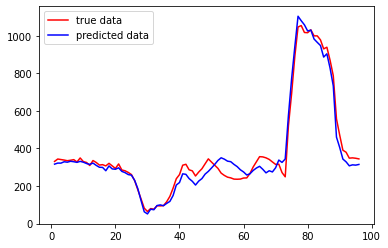

In [59]:
plot_validate_data(2)

In [55]:
nmae = np.mean(
    [np.mean(np.abs(y0.flatten()[-NUM_TIME_BUCKETS:]-y1.flatten()[-NUM_TIME_BUCKETS:])) / (max(y0.flatten()[-NUM_TIME_BUCKETS:]) - min(y0.flatten()[-NUM_TIME_BUCKETS:]))  for y0, y1 in zip(y_validate, y_validate_predict)]
)

In [56]:
nmae

0.07684840413489856

In [57]:
df_validate = df_join[((df_join['Date'] >= pd.Timestamp(VALIDATE_DS_START)) & (df_join['Date'] <= pd.Timestamp(VALIDATE_DS_START + timedelta(days=1))))]
x_validate, y_validate = split_feature_labels(df_validate)
y_validate_predict = model.predict(x_validate, batch_size = BATCH_SIZE)
print(
    np.mean([np.mean(np.abs(y0.flatten()[-NUM_TIME_BUCKETS:]-y1.flatten()[-NUM_TIME_BUCKETS:])) / (max(y0.flatten()[-NUM_TIME_BUCKETS:]) - min(y0.flatten()[-NUM_TIME_BUCKETS:]))  for y0, y1 in zip(y_validate, y_validate_predict)])
)

(192, 192, 1) (192, 192, 1)
0.08120888172982169
